In [1]:
import keras

Using TensorFlow backend.


In [2]:
num_words = 50000
maxlen = 500  # cut texts after this number of words
embedding_dim = 32

# Data Processing

In [3]:
from keras.datasets import reuters

(input_train, y_train), (input_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

8982 train sequences
2246 test sequences


In [4]:
from keras.preprocessing import sequence

input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)

print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

input_train shape: (8982, 500)
input_test shape: (2246, 500)
y_train shape: (8982,)
y_test shape: (2246,)


In [5]:
num_classes = max(y_train) + 1
print('# of Classes: ',num_classes)

# of Classes:  46


In [6]:
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# CNN Model Setup

In [10]:
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Embedding
from keras.layers import Dense, Input, Flatten, Reshape, concatenate, Dropout
from keras.models import Model
from keras import optimizers
import numpy as np

embedding_matrix = np.zeros((num_words, embedding_dim))

embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)

sequence_input = Input(shape=(maxlen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
print(embedded_sequences.shape)


# add first conv filter
embedded_sequences = Reshape((maxlen, embedding_dim, 1))(embedded_sequences)
x = Conv2D(100, (5, embedding_dim), activation='relu')(embedded_sequences)
x = MaxPooling2D((maxlen - 5 + 1, 1))(x)


# add second conv filter.
y = Conv2D(100, (4, embedding_dim), activation='relu')(embedded_sequences)
y = MaxPooling2D((maxlen - 4 + 1, 1))(y)


# add third conv filter.
z = Conv2D(100, (3, embedding_dim), activation='relu')(embedded_sequences)
z = MaxPooling2D((maxlen - 3 + 1, 1))(z)


# concate the conv layers
alpha = concatenate([x,y,z])

# flatted the pooled features.
alpha = Flatten()(alpha)

# dropout
alpha = Dropout(0.5)(alpha)

# predictions
preds = Dense(num_classes, activation='softmax')(alpha)

# build model
model = Model(sequence_input, preds)
adadelta = optimizers.Adadelta()

model.compile(loss='categorical_crossentropy',
              optimizer=adadelta,
              metrics=['acc'])


Instructions for updating:
Colocations handled automatically by placer.
(?, 500, 32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 32)      1600000     input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 500, 32, 1)   0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 496, 1, 100)  16100       reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (

In [12]:
batch_size = 64 # number of examples per batch
n_epochs = 10   # number of epochs to train - each epoch is a full pass in the entire trainset   
validation_split = 0.3  # split from the trainset to be used to compute validation scores - the accuracy on an independent set of examples

history = model.fit(input_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_split=validation_split)

Instructions for updating:
Use tf.cast instead.
Train on 6287 samples, validate on 2695 samples
Epoch 1/10
6287/6287 [==============================] - 14s 2ms/step - loss: 3.7471 - acc: 0.2003 - val_loss: 3.6597 - val_acc: 0.2215
Epoch 2/10
6287/6287 [==============================] - 13s 2ms/step - loss: 3.5821 - acc: 0.2150 - val_loss: 3.4947 - val_acc: 0.2215
Epoch 3/10
6287/6287 [==============================] - 13s 2ms/step - loss: 3.4222 - acc: 0.3129 - val_loss: 3.3362 - val_acc: 0.3532
Epoch 4/10
6287/6287 [==============================] - 14s 2ms/step - loss: 3.2705 - acc: 0.3510 - val_loss: 3.1866 - val_acc: 0.3532
Epoch 5/10
6287/6287 [==============================] - 14s 2ms/step - loss: 3.1285 - acc: 0.3510 - val_loss: 3.0484 - val_acc: 0.3532
Epoch 6/10
6287/6287 [==============================] - 14s 2ms/step - loss: 2.9989 - acc: 0.3510 - val_loss: 2.9238 - val_acc: 0.3532
Epoch 7/10
6287/6287 [==============================] - 14s 2ms/step - loss: 2.8837 - acc: 0.3

# Performance Plot

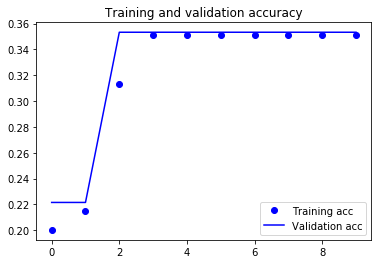

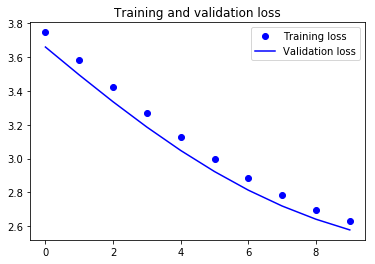

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()